# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os, sys
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break

import sys


from data_wrangling import general_utils, specific_utils, process_monkey_information, base_processing_class, retrieve_raw_data, further_processing_class
from pattern_discovery import pattern_by_trials, pattern_by_points, make_ff_dataframe, ff_dataframe_utils, pattern_by_trials, pattern_by_points, cluster_analysis, organize_patterns_and_features, category_class
from decision_making_analysis.cluster_replacement import cluster_replacement_utils, plot_cluster_replacement
from decision_making_analysis.decision_making import decision_making_utils, plot_decision_making, intended_targets_classes
from decision_making_analysis.GUAT import GUAT_helper_class, GUAT_collect_info_class, GUAT_combine_info_class, add_features_GUAT_and_TAFT
from decision_making_analysis import free_selection, replacement, trajectory_info
from visualization.matplotlib_tools import plot_trials, plot_polar, additional_plots, plot_behaviors_utils, plot_statistics, monkey_heading_utils
from visualization.animation import animation_func, animation_utils, animation_class
from machine_learning.ml_methods import regression_utils, classification_utils, prep_ml_data_utils, hyperparam_tuning_class
from machine_learning.RL.env_related import env_for_lstm, env_utils, base_env, collect_agent_data, process_agent_data
from machine_learning.RL.lstm import GRU_functions, LSTM_functions
from machine_learning.RL.SB3 import interpret_neural_network, sb3_for_multiff_class, rl_for_multiff_utils, SB3_functions
from null_behaviors import show_null_trajectory, find_best_arc, curvature_utils
from decision_making_analysis.decision_making import decision_making_class, decision_making_utils, intended_targets_classes

import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from os.path import exists
import seaborn as sns
import math
import copy
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from scipy import stats
from IPython.display import HTML
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, hamming_loss, multilabel_confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from math import pi
from scipy.ndimage import gaussian_filter1d
from importlib import reload

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
pd.options.display.max_rows = 101



Set up logging configuration.


/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# Basic data

## Retrieve monkey data

In [2]:
PLAYER = "monkey"
trial_total_num = 2

raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
data_item = animation_class.AnimationClass(raw_data_folder_path=raw_data_folder_path)
data_item.retrieve_or_make_monkey_data(exists_ok=True, min_distance_to_calculate_angle=10)
data_item.make_or_retrieve_ff_dataframe(exists_ok=True)
data_item.find_patterns()

monkey_information = data_item.monkey_information
ff_dataframe = data_item.ff_dataframe

ff_life_sorted = data_item.ff_life_sorted
ff_real_position_sorted = data_item.ff_real_position_sorted
ff_believed_position_sorted = data_item.ff_believed_position_sorted
cluster_around_target_indices = data_item.cluster_around_target_indices
ff_caught_T_new = data_item.ff_caught_T_new
caught_ff_num = len(ff_caught_T_new)
ff_flash_sorted = data_item.ff_flash_sorted
ff_flash_end_sorted = data_item.ff_flash_end_sorted
max_point_index = data_item.max_point_index
min_point_index = data_item.min_point_index

data_item.make_or_retrieve_target_clust_last_vis_df()
target_clust_last_vis_df = data_item.target_clust_last_vis_df
target_clust_last_vis_df['ff_index'] = target_clust_last_vis_df['target_index']

data_item.make_curvature_df()
data_item.make_or_retrieve_best_arc_df()
data_item.null_arc_info_for_plotting = show_null_trajectory.find_and_package_opt_arc_info_for_plotting(data_item.best_arc_df, data_item.monkey_information, column_for_color=None, ignore_error=True)


# data_item.make_or_retrieve_all_trial_patterns(exists_ok=True)
# data_item.make_or_retrieve_pattern_frequencies(exists_ok=True)
# data_item.make_or_retrieve_all_trial_features(exists_ok=True)
# data_item.make_or_retrieve_feature_statistics(exists_ok=True)
# data_item.make_info_of_monkey()
# data_item.make_or_retrieve_target_closest()
# data_item.make_or_retrieve_target_angle_smallest()

# target_closest = data_item.target_closest
# target_angle_smallest = data_item.target_angle_smallest
# all_trial_patterns = data_item.all_trial_patterns
# all_trial_features = data_item.all_trial_features
# pattern_frequencies = data_item.pattern_frequencies
# feature_statistics = data_item.feature_statistics
# info_of_monkey = data_item.info_of_monkey

# data_item.make_PlotTrials_args()
# data_item.make_PlotTrials_kargs(classic_plot_kwargs, combined_plot_kwargs, animation_plot_kwargs)

PlotTrials_args = (monkey_information, ff_dataframe, ff_life_sorted, ff_real_position_sorted, ff_believed_position_sorted, cluster_around_target_indices, ff_caught_T_new)

plot_polar_args = (monkey_information,
                    ff_dataframe, 
                    ff_life_sorted,
                    ff_real_position_sorted,
                    ff_caught_T_new,
                    ff_flash_sorted,)


classic_plot_kwargs = {'player': PLAYER,
                       'show_stops': True,
                       'show_believed_target_positions': True,
                       'show_reward_boundary': True,
                       'show_scale_bar': True,
                       'show_eye_positions': True,
                       'show_eye_positions_on_the_right': True,
                       'show_connect_path_eye_positions': True,
                       #=== below is different from animation_plot_kwargs
                       'hitting_arena_edge_ok': False,
                       'trial_too_short_ok': False}

combined_plot_kwargs = {'player': PLAYER,
                        'combined_plot': True,
                        'show_alive_fireflies': False,
                        'show_title': False,
                        'show_start': False}

plot_chunks_kwargs = {'player': PLAYER,
                      'show_stops': True,
                      'show_believed_target_positions': True,
                      'show_reward_boundary': True,
                      'show_scale_bar': True,
                      'hitting_arena_edge_ok': True,
                      'trial_too_short_ok': True,
                      'show_connect_path_ff': True,
                      'trail_color_var': 'abs_ddw',
                      'show_colorbar': True}


plot_polar_kwargs = {'rmax': 400,
                    'show_visible_ff': True,
                    'hitting_arena_edge_ok': True,
                    'return_axes': True,
                    'colors_show_overall_time': True,
                    'show_ff_in_memory': True,
                    'show_target_at_being_caught': True
                    }

animation_plot_kwargs = {
    **classic_plot_kwargs,
    'as_part_of_animation': True,
    'show_eye_positions_on_the_right': False,
    'hitting_arena_edge_ok': True,
    'trial_too_short_ok': True,
    'images_dir': None
}
  
data_item.make_PlotTrials_args()
data_item.make_PlotTrials_kargs(classic_plot_kwargs, combined_plot_kwargs, animation_plot_kwargs)


plotting_kwargs = {'player': 'monkey',
 'show_stops': True,
 'show_believed_target_positions': True,
 'show_reward_boundary': True,
 'show_scale_bar': True,
 'hitting_arena_edge_ok': True,
 'trial_too_short_ok': True,
 'show_connect_path_ff': True,
 'vary_color_for_connecting_path_ff': True,
 'show_points_when_ff_stop_being_visible': False,
 #'show_connect_path_ff_memory': True,
 'show_alive_fireflies': False,
 'show_visible_fireflies': True,
 'show_in_memory_fireflies': True,
 'connect_path_ff_max_distance': 400,
 #'show_connect_path_ff_except_targets': True,
 'adjust_xy_limits': True,
 'show_null_agent_trajectory': True,
 'show_only_ff_that_monkey_has_passed_by_closely': True,
 'show_null_trajectory_reaching_boundary_ok': False,
 'vary_color_for_connecting_path_ff': False}

plotting_kwargs['null_arc_info_for_plotting'] = data_item.null_arc_info_for_plotting



Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0330/ff_dataframe.h5
When take out monkey subset for GUAT, 643 clusters out of 856 are too close to the target or the last target. Those clusters are filtered out.
The number of new trials that are used to separate stop clusters is 1338
Retrieved target_clust_last_vis_df
Number of unique ff in the dropped rows: 1416


# Trial visualization

## Plot from a category

In [3]:
plt.rcParams["figure.figsize"] = (7, 7) 
data_item.plot_trials_from_a_category('two_in_a_row', max_trial_to_plot=2, images_dir=None, figsize=(7,7)) # if want to save the plot, pass in an argument for images_dir

currentTrial: 9 num_trials: 2
currentTrial: 17 num_trials: 2
duration: [np.float64(79.205382), np.float64(83.504722)]


<Figure size 700x700 with 0 Axes>

currentTrial: 27 num_trials: 2
duration: [np.float64(104.005274), np.float64(105.864524)]


## Polar plots

100


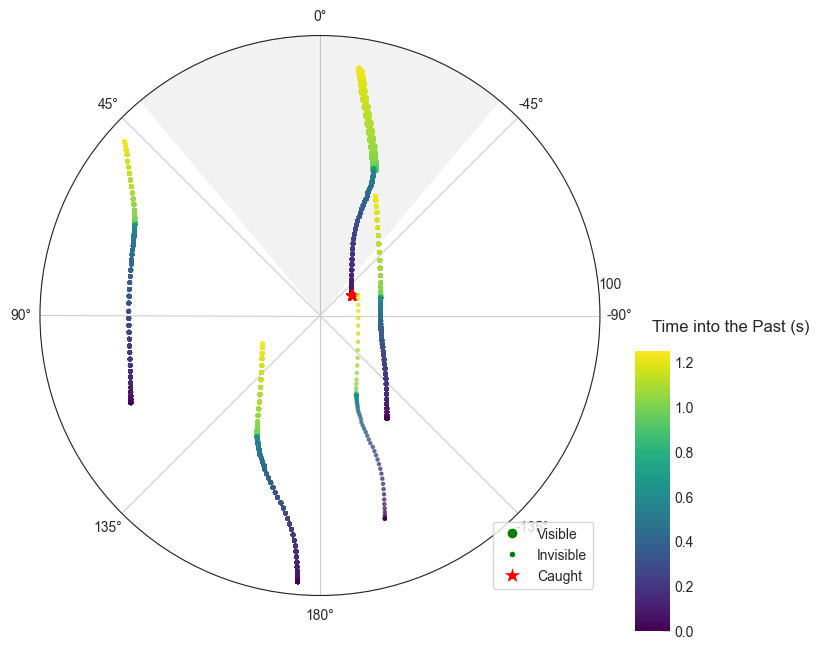

101


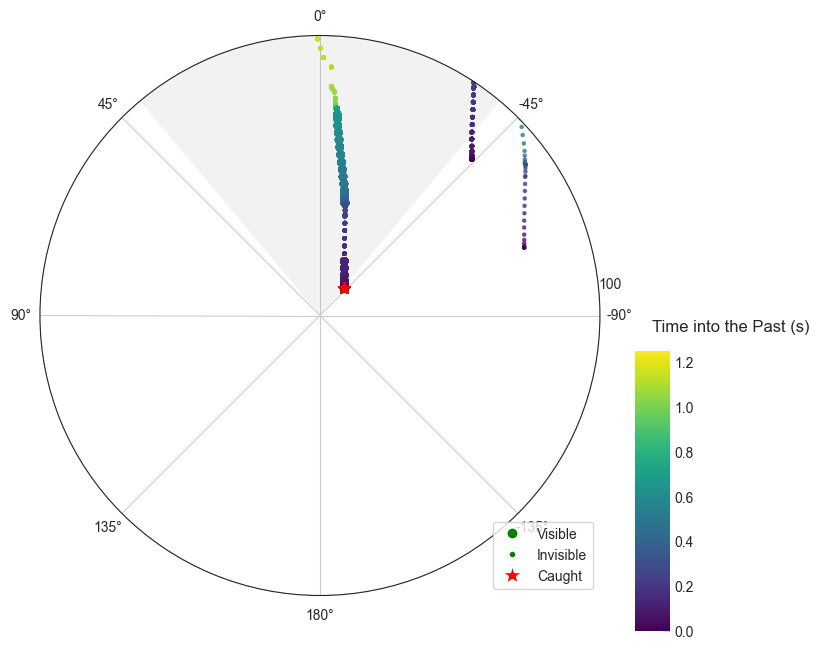

102


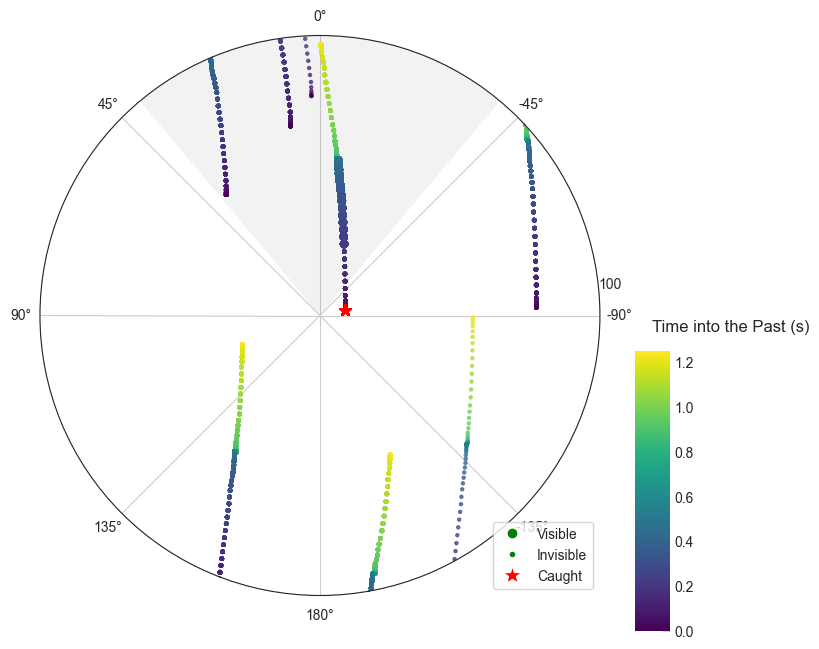

103


104


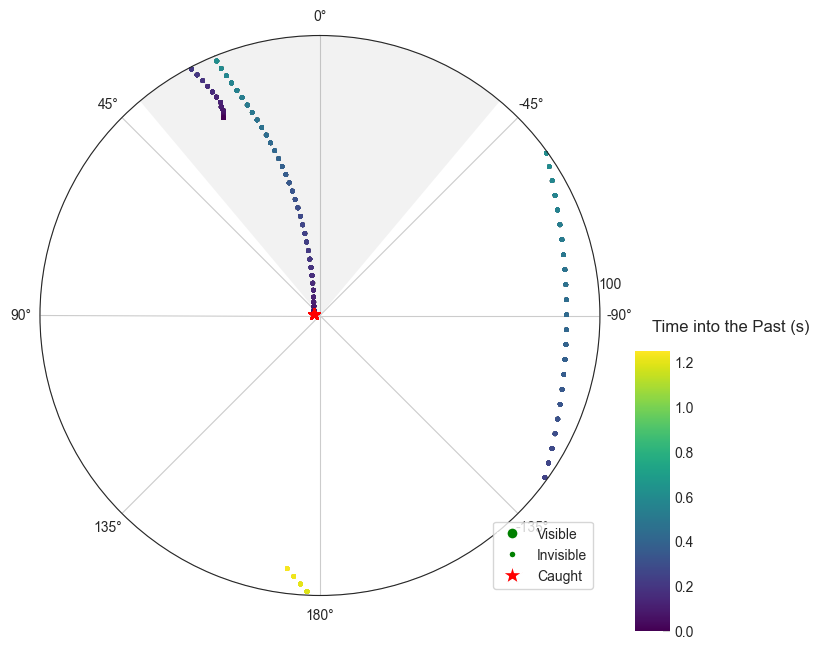

In [4]:
num_trials = 1
for currentTrial in range(100, 105):
    print(currentTrial)
    #duration = [ff_caught_T_new[currentTrial-num_trials], ff_caught_T_new[currentTrial]]
    duration = [ff_caught_T_new[currentTrial]-1.25, ff_caught_T_new[currentTrial]]


    plot_polar.PlotPolar(duration,
              monkey_information,
              ff_dataframe, 
              ff_life_sorted,
              ff_real_position_sorted,
              ff_caught_T_new,
              ff_flash_sorted,
              rmax = 100,
              currentTrial = currentTrial,
              num_trials = num_trials,
              show_visible_ff = True,
              show_visible_target = True,
              # show_ff_in_memory = True,
              # show_target_in_memory = True,
              ff_colormap = 'viridis',
              target_colormap = 'viridis',
              show_alive_ff = True,
              colors_show_overall_time = True,
              show_all_positions_of_all_fireflies = True,
              show_colorbar = True,
                )

# New ways to define chunks (rather than defining trials based on targets)

## (1) Change in speed

A new chunk happens when the monkey/agent changes its speed from below half of the full speed to above half of the full speed

In [5]:
from data_wrangling import specific_utils
chunk_numbers, new_chunk_indices = specific_utils.reorganize_data_into_chunks(monkey_information)

In [6]:
PlotTrials_args = (monkey_information, ff_dataframe, ff_life_sorted, ff_real_position_sorted, \
                   ff_believed_position_sorted, cluster_around_target_indices, ff_caught_T_new)

In [7]:
# Plot a chunk
starting_chunk = 150
num_of_chunks = 6

cum_pos_index = np.where((chunk_numbers >= starting_chunk) & (chunk_numbers < starting_chunk+num_of_chunks))[0]
duration = [monkey_information['time'][cum_pos_index[0]], monkey_information['time'][cum_pos_index[-1]]]


with general_utils.initiate_plot(7, 7, 100):
    plot_trials.PlotTrials(duration, 
                *PlotTrials_args,
                trail_color_var = "speed",
                show_stops = True,
                show_believed_target_positions = True,
                show_reward_boundary = True,
                show_connect_path_ff = True,
                show_scale_bar = True,
                hitting_arena_edge_ok = True,
                trial_too_short_ok = True,
                show_title = False,
                steps_to_be_marked = new_chunk_indices[starting_chunk+1:starting_chunk+num_of_chunks]-cum_pos_index[0],
                )
    



    plt.show()  
    

currentTrial: 54 num_trials: 1
duration: [np.float64(154.036858), np.float64(156.593098)]


<Figure size 700x700 with 0 Axes>

## (2) Group points where 2+ ff are visible

In [8]:
chunk_interval = 10
points_w_more_than_2_ff = pattern_by_points.find_points_w_more_than_n_ff(ff_dataframe, monkey_information, ff_caught_T_new)
points_w_more_than_2_ff = pattern_by_points.decrease_overlaps_between_chunks(points_w_more_than_2_ff, monkey_information, min_interval_between_chunks=chunk_interval)

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(


In [9]:
plot_chunks_kwargs1 = {
    **plot_chunks_kwargs,
    'trail_color_var': None,
    'show_colorbar': False,
    'show_alive_fireflies': False,
    'show_legend': True,
    'vary_color_for_connecting_path_ff': True,
    'show_null_agent_trajectory': True,
    'show_null_agent_trajectory_2nd_time': True,
    'minimal_margin': 50,
    'null_arc_info_for_plotting': data_item.null_arc_info_for_plotting,
}


plot_chunks_kwargs2 = {'player': 'monkey',
 'show_stops': True,
 'show_believed_target_positions': True,
 'show_alive_fireflies': False,
 'show_scale_bar': False,
 'hitting_arena_edge_ok': True,
 'trial_too_short_ok': True,
 'show_connect_path_ff': True,
 'trail_color_var': None,
 'show_colorbar': False,
 'adjust_xy_limits': False,
 'vary_color_for_connecting_path_ff': True,
 'show_reward_boundary': True,
 'null_arc_info_for_plotting': data_item.null_arc_info_for_plotting,
 }

points_w_more_than_2_ff.chunk.max()

124

### overhead

In [10]:
# plot the chunks
for chunk in range(70,72):
  with general_utils.initiate_plot(7, 7, 100):
    chunk_df = points_w_more_than_2_ff[points_w_more_than_2_ff['chunk'] == chunk]
    duration_points = [chunk_df['point_index'].min(), chunk_df['point_index'].max()]
    #duration = [monkey_information['time'][duration_points[0]], monkey_information['time'][duration_points[1]]]
    duration = [monkey_information['time'][duration_points[0]], monkey_information['time'][duration_points[0]]+5]
    print("duration", duration)

    returned_info = plot_trials.PlotTrials(duration,
               *PlotTrials_args,
               **plot_chunks_kwargs)

    axes = returned_info['axes']           
    axes.set_title('Chunk ' + str(chunk), fontsize=17)
    plt.show()
    

duration [np.float64(1821.292803), np.float64(1826.292803)]
currentTrial: 708 num_trials: 2
duration: [np.float64(1821.292803), np.float64(1826.292803)]


<Figure size 700x700 with 0 Axes>

duration [np.float64(1830.389396), np.float64(1835.389396)]
currentTrial: 713 num_trials: 1
duration: [np.float64(1830.389396), np.float64(1835.389396)]


<Figure size 700x700 with 0 Axes>

### overhead: 2 plots (second shows extended duration)

duration [np.float64(432.961325), np.float64(434.961325)]
currentTrial: 157 num_trials: 1
duration: [np.float64(432.961325), np.float64(434.961325)]
1st arch:
If type = 'most_alignt', show_null_agent_trajectory_2nd_time cannot be True. This command is ignored.


<Figure size 700x700 with 0 Axes>

currentTrial: 157 num_trials: 1
duration: [np.float64(432.961325), np.float64(434.961325)]
1st arch:
If type = 'most_alignt', show_null_agent_trajectory_2nd_time cannot be True. This command is ignored.
currentTrial: 159 num_trials: 2
duration: [np.float64(434.961325), np.float64(436.961325)]


duration [np.float64(446.24115), np.float64(448.24115)]
currentTrial: 165 num_trials: 1
duration: [np.float64(446.24115), np.float64(448.24115)]
1st arch:
If type = 'most_alignt', show_null_agent_trajectory_2nd_time cannot be True. This command is ignored.


<Figure size 700x700 with 0 Axes>

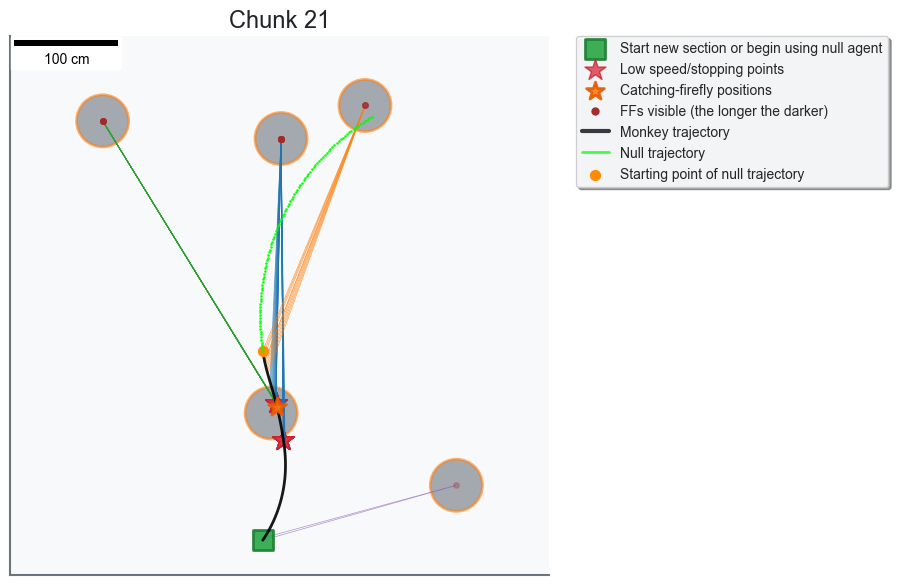

currentTrial: 165 num_trials: 1
duration: [np.float64(446.24115), np.float64(448.24115)]
1st arch:
If type = 'most_alignt', show_null_agent_trajectory_2nd_time cannot be True. This command is ignored.
currentTrial: 166 num_trials: 1
duration: [np.float64(448.24115), np.float64(450.24115)]


In [11]:
## Note: two plots are made for each chunk, with the 1st plot being the zoomed-in version of the 2nd plot
for chunk in range(20, 22):
  with general_utils.initiate_plot(7, 7, 100):
    chunk_df = points_w_more_than_2_ff[points_w_more_than_2_ff['chunk'] == chunk]
    if len(chunk_df) == 0:
        print('No data for chunk', chunk)
        continue
    duration_points = [chunk_df['point_index'].min(), chunk_df['point_index'].max()]
    #duration = [monkey_information['time'][duration_points[0]], monkey_information['time'][duration_points[1]]]
    duration = [monkey_information['time'][duration_points[0]], monkey_information['time'][duration_points[0]]+2]
    print("duration", duration)

    
    for i in range(2):
        fig = plt.figure()
        returned_info = plot_trials.PlotTrials(duration,
                  *PlotTrials_args,
                  **plot_chunks_kwargs1,
                  fig=fig)
        fig, axes = returned_info['fig'], returned_info['axes']
        R = returned_info['rotation_matrix']
        cum_mxy_rotated_1 = returned_info['cum_mxy_rotated']
        shown_ff_indices_1 = returned_info['shown_ff_indices']
        
        if i == 1:
            duration2 = [duration[1], duration[1]+2]
            returned_info = plot_trials.PlotTrials(duration2,
            *PlotTrials_args,
            **plot_chunks_kwargs2,
            fig=fig,
            axes=axes,
            rotation_matrix=R)
            axes = returned_info['axes']
            cum_mxy_rotated_2 = returned_info['cum_mxy_rotated']
            shown_ff_indices_2 = returned_info['shown_ff_indices']

            plot_behaviors_utils.readjust_xy_limits_for_axes(axes, cum_mxy_rotated_1, cum_mxy_rotated_2, shown_ff_indices_1, shown_ff_indices_2, R, ff_real_position_sorted, minimal_margin=50)

        axes.set_aspect('equal')
        axes.set_title('Chunk ' + str(chunk), fontsize=17)
        plt.show()
        

### polar

duration [np.float64(1821.292803), np.float64(1823.292803)]


<Figure size 700x700 with 0 Axes>

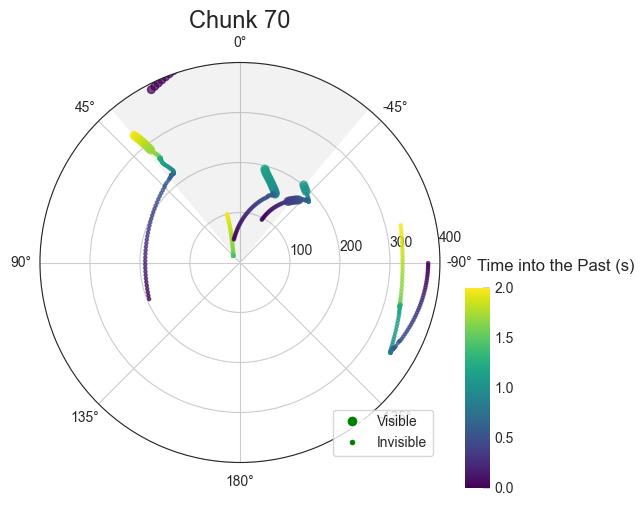

duration [np.float64(1830.389396), np.float64(1832.389396)]


<Figure size 700x700 with 0 Axes>

duration [np.float64(1857.446898), np.float64(1859.446898)]


<Figure size 700x700 with 0 Axes>

In [12]:
# plot the chunks
for chunk in range(70,73):
  with general_utils.initiate_plot(7, 7, 100):
    chunk_df = points_w_more_than_2_ff[points_w_more_than_2_ff['chunk'] == chunk]
    duration_points = [chunk_df['point_index'].min(), chunk_df['point_index'].max()]
    #duration = [monkey_information['time'][duration_points[0]], monkey_information['time'][duration_points[1]]]
    duration = [monkey_information['time'][duration_points[0]], monkey_information['time'][duration_points[0]]+2]
    print("duration", duration)

    fig, axes = plot_polar.PlotPolar(duration,
                *plot_polar_args,
                **plot_polar_kwargs,
                ff_colormap = 'viridis',
                target_colormap = 'viridis',
                figsize=(5,5)
                    )
    axes.set_title('Chunk ' + str(chunk), fontsize=17)
    plt.show()
    



### polar plot: 2 plots (second shows extended duration)

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(


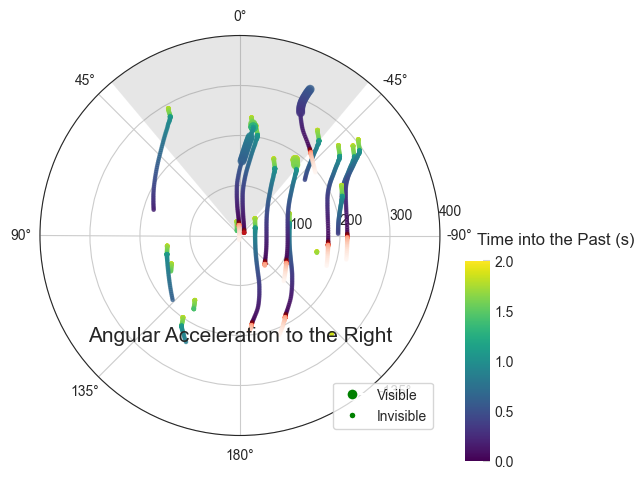

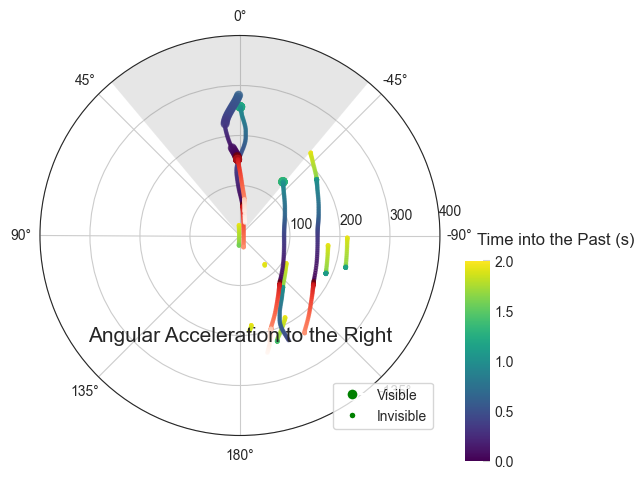

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(


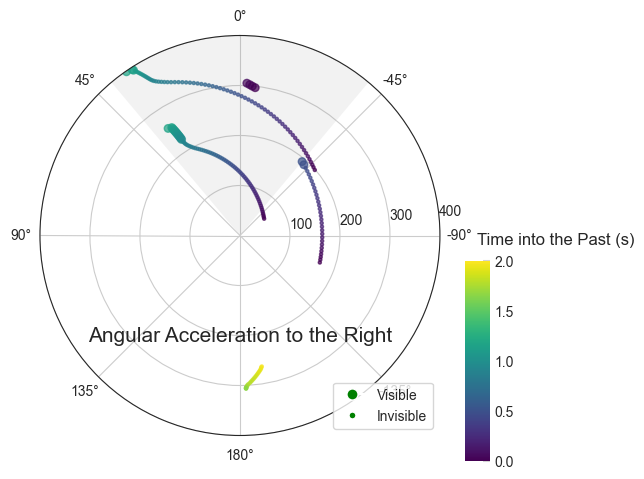

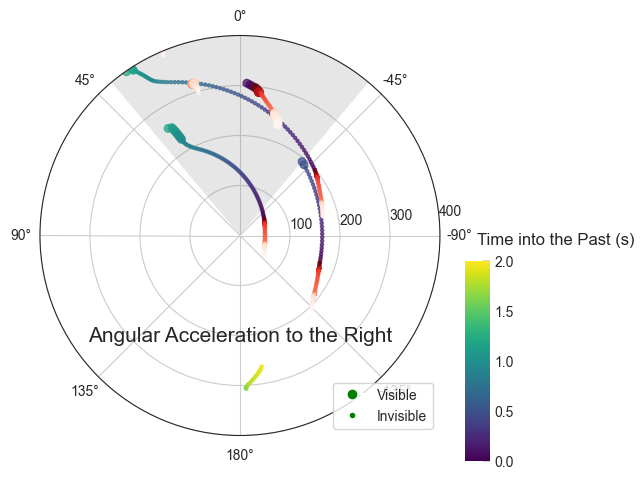

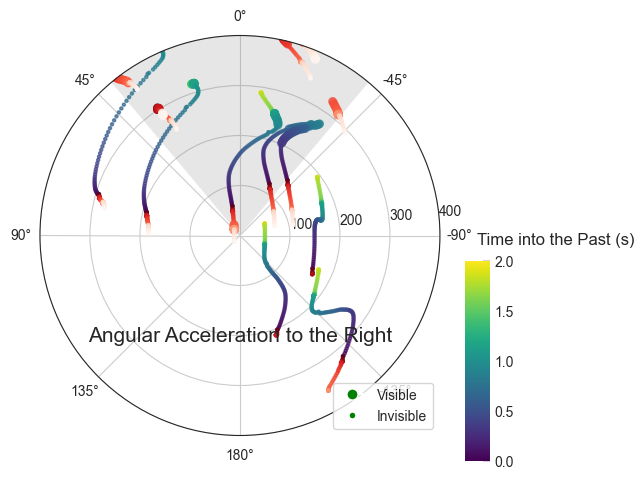

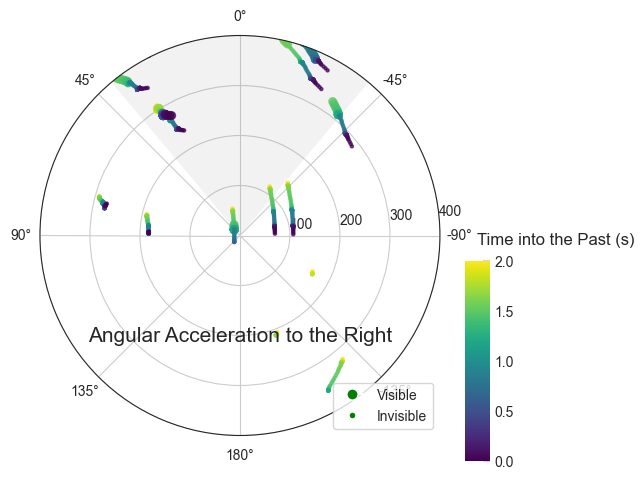

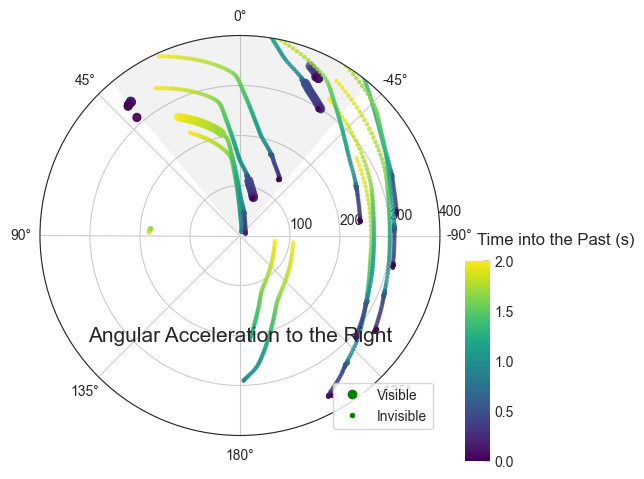

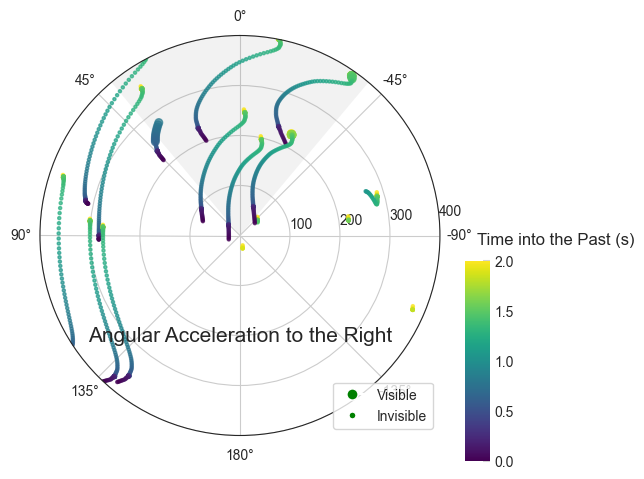

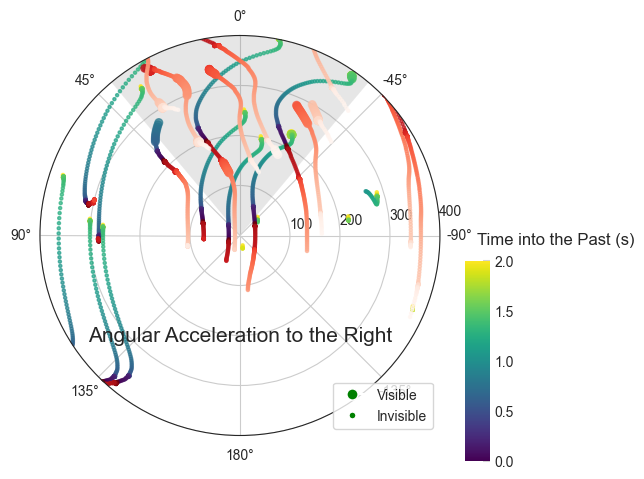

In [13]:
chunk_numbers = range(20, 22)

plt.rcParams["figure.figsize"] = (7, 7)


for chunk in chunk_numbers:
  chunk_df = points_w_more_than_2_ff[points_w_more_than_2_ff['chunk'] == chunk]
  if len(chunk_df) == 0:
    raise ValueError(f"Chunk {chunk} has no data")
  changing_dw_info = pattern_by_points.find_changing_dw_info(chunk_df, monkey_information, ff_caught_T_new, chunk_interval=10,
                                             minimum_time_before_capturing = 0.5)
  changing_dw_info = pattern_by_points.increase_durations_between_points(changing_dw_info, min_duration=2)
  for index, row in changing_dw_info.iterrows():
      point_index = row['point_index']
      ddw = row['ddw']
      duration = [monkey_information['time'][point_index]-2, monkey_information['time'][point_index]]
      # if dw > 0:
      #     # flip so that the monkey is always going towards its right side
      #     ff_dataframe_sub['ff_angle'] = -ff_dataframe_sub['ff_angle']
    
      # plot_trials.PlotTrials(duration,
      #     *PlotTrials_args,
      #     **plot_chunks_kwargs,
      #     show_connect_path_ff_memory=True)
      
      duration2 = [duration[1], min(duration[1]+5, ff_caught_T_new[ff_caught_T_new > duration[1]][0]+0.5)]
      # Make a polar plot from the monkey's perspective in the duration
      for i in range(2):
          fig, axes = plot_polar.PlotPolar(duration,
                      *plot_polar_args,
                      **plot_polar_kwargs,
                      ff_colormap = 'viridis',
                      target_colormap = 'viridis',
                      figsize = (5, 5)
                          )
          if i == 1:
              fig, axes = plot_polar.PlotPolar(duration2,
                          *plot_polar_args,
                          **plot_polar_kwargs,          
                          ff_colormap = 'Reds',
                          target_colormap = 'Reds',
                          fig = fig,
                          ax = axes,
                          show_colorbar = False,
                          figsize = (5, 5)
                              )          
          
          
          # Add an annotation at the bottom
          if ddw > 0: 
            annotation = "Angular Acceleration to the Left"
          else:
            annotation = "Angular Acceleration to the Right"
          axes.annotate(annotation, xy=(0.5, 0.25), xycoords="axes fraction", fontsize=15, ha="center", va="center")
          
          plt.show()
            

## plot sub-chunks with high abs ddw

### individual segments

In [14]:
chunk_interval = 10
points_w_more_than_2_ff = pattern_by_points.find_points_w_more_than_n_ff(ff_dataframe, monkey_information, ff_caught_T_new)
points_w_more_than_2_ff = pattern_by_points.decrease_overlaps_between_chunks(points_w_more_than_2_ff, monkey_information, min_interval_between_chunks=chunk_interval)

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(


/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(


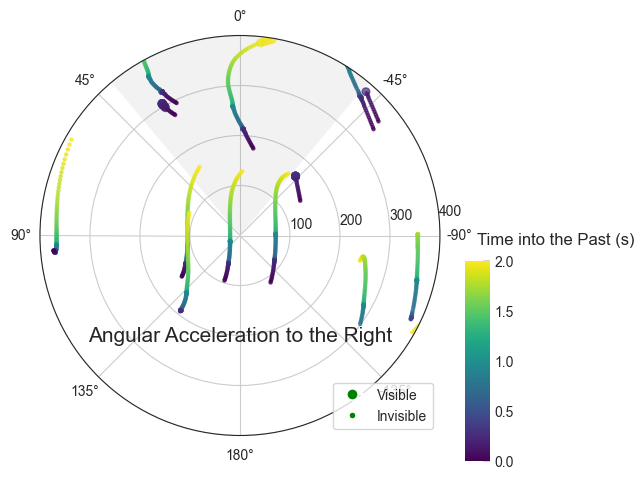

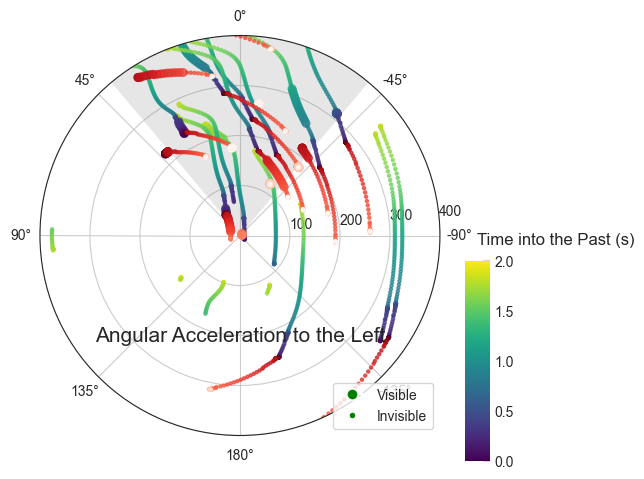

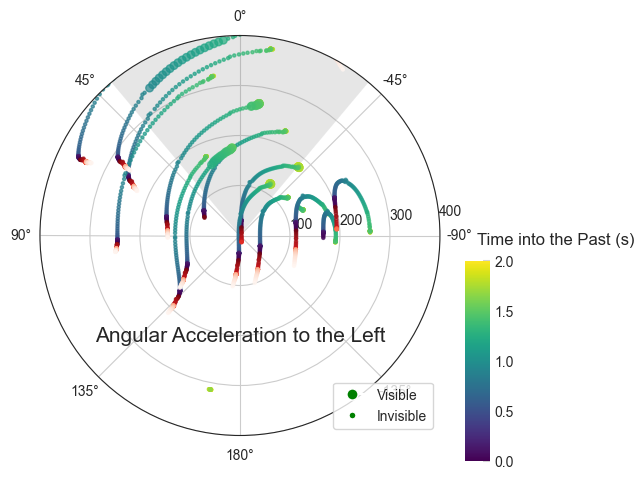

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(


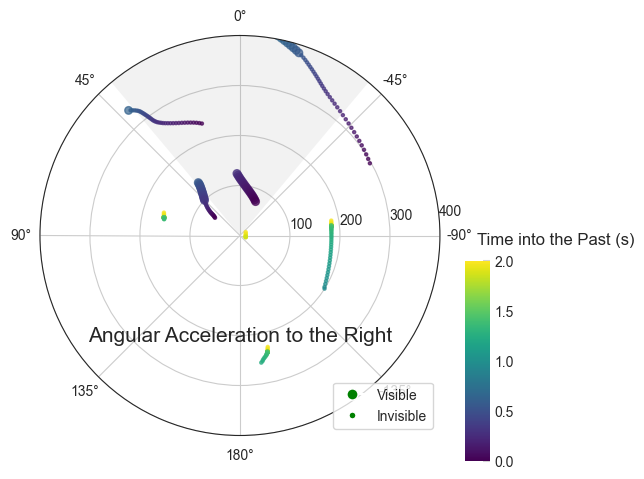

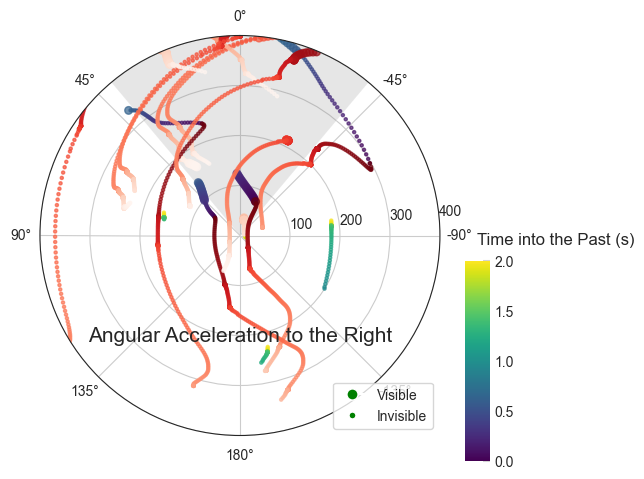

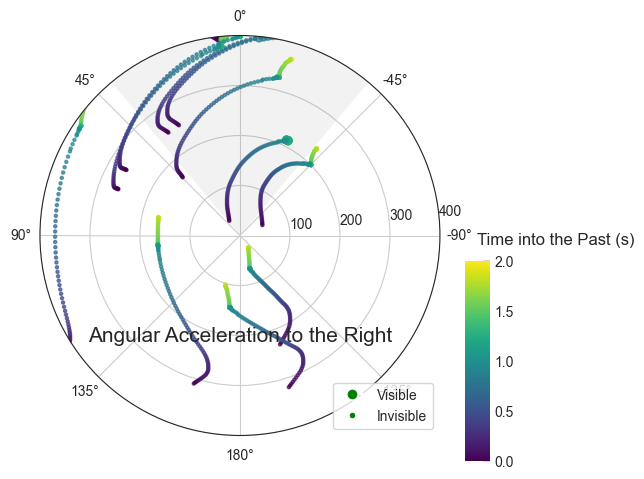

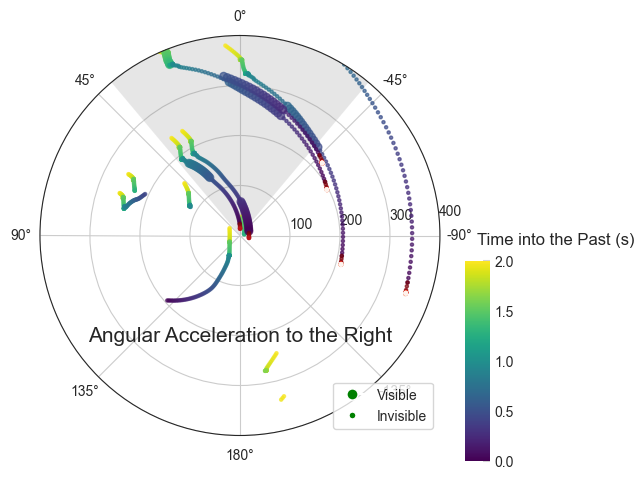

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(


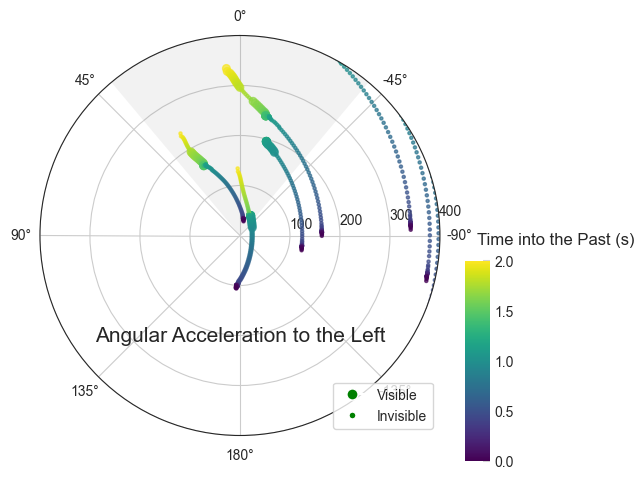

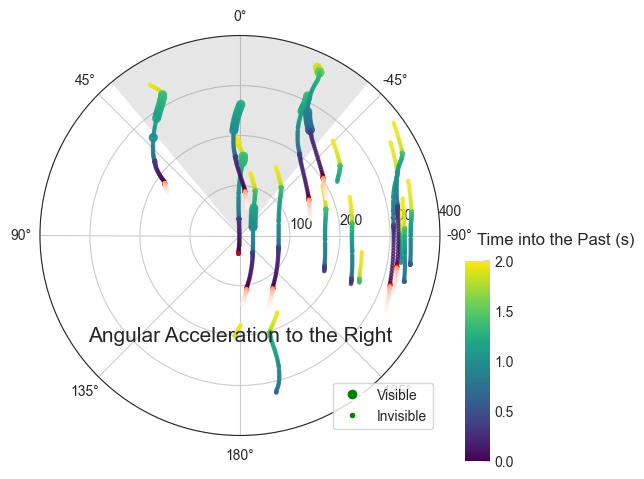

In [15]:
chunk_numbers = range(50, 53)

for chunk in chunk_numbers:

  chunk_df = points_w_more_than_2_ff[points_w_more_than_2_ff['chunk'] == chunk]
  if len(chunk_df) == 0:
    raise ValueError(f"Chunk {chunk} has no data")
  changing_dw_info = pattern_by_points.find_changing_dw_info(chunk_df, monkey_information, ff_caught_T_new, chunk_interval=10,
                                             minimum_time_before_capturing = 0.5)
  changing_dw_info = pattern_by_points.increase_durations_between_points(changing_dw_info, min_duration=2)
  for index, row in changing_dw_info.iterrows():
      point_index = row['point_index']
      ddw = row['ddw']
      duration = [monkey_information['time'][point_index]-2, monkey_information['time'][point_index]]
      # if dw > 0:
      #     # flip so that the monkey is always going towards its right side
      #     ff_dataframe_sub['ff_angle'] = -ff_dataframe_sub['ff_angle']
    
      # plot_trials.PlotTrials(duration,
      #     *PlotTrials_args,
      #     **plot_chunks_kwargs,
      #     show_connect_path_ff_memory=True)
      
      duration2 = [duration[1], min(duration[1]+5, ff_caught_T_new[ff_caught_T_new > duration[1]][0]+0.5)]
      # Make a polar plot from the monkey's perspective in the duration
      for i in range(2):
          fig, axes = plot_polar.PlotPolar(duration,
                      *plot_polar_args,
                      **plot_polar_kwargs,
                      ff_colormap = 'viridis',
                      target_colormap = 'viridis',
                      figsize = (5,5)
                          )
          if i == 1:
              fig, axes = plot_polar.PlotPolar(duration2,
                          *plot_polar_args,
                          **plot_polar_kwargs,          
                          ff_colormap = 'Reds',
                          target_colormap = 'Reds',
                          fig = fig,
                          ax = axes,
                          show_colorbar = False
                              )          
          
          
          # Add an annotation at the bottom
          if ddw > 0: 
            annotation = "Angular Acceleration to the Left"
          else:
            annotation = "Angular Acceleration to the Right"
          axes.annotate(annotation, xy=(0.5, 0.25), xycoords="axes fraction", fontsize=15, ha="center", va="center")
          
          
          plt.show()
            

### overlaid on trials: viridis
Note: some data are flipped in their angles so that the monkey is always going towards its right side

In [16]:
fig = plt.figure(figsize=(7, 7))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
chunk_numbers = range(110, 115)
counter = 0
max_overlapped_plots = 100
plot_polar_kwargs_temp = plot_polar_kwargs.copy()
plot_polar_kwargs_temp['show_ff_in_memory'] = False

color_visible_area_in_background = True
show_colorbar = True
for chunk in chunk_numbers:
  chunk_df = points_w_more_than_2_ff[points_w_more_than_2_ff['chunk']== chunk]
  if len(chunk_df) == 0:
    raise ValueError(f"Chunk {chunk} has no data")
  changing_dw_info = pattern_by_points.find_changing_dw_info(chunk_df, monkey_information, ff_caught_T_new, chunk_interval=10,
                                             minimum_time_before_capturing = 0.5)
  changing_dw_info = pattern_by_points.increase_durations_between_points(changing_dw_info, min_duration=2)
  
  for index, row in changing_dw_info.iterrows():
      counter += 1
      point_index = row['point_index']
      ddw = row['ddw']
      duration = [monkey_information['time'][point_index]-0.2, monkey_information['time'][point_index]]
      ff_dataframe_temp = ff_dataframe.copy()
      if ddw > 0:
          # flip so that the monkey is always going towards its right side
          ff_dataframe_temp['ff_angle'] = -ff_dataframe_temp['ff_angle']
    

      fig, axes = plot_polar.PlotPolar(duration,
                  monkey_information,
                  ff_dataframe_temp, 
                  ff_life_sorted,
                  ff_real_position_sorted,
                  ff_caught_T_new,
                  ff_flash_sorted,
                  **plot_polar_kwargs_temp,
                  ff_colormap = 'viridis',
                  target_colormap = 'viridis',
                  show_legend = False,
                  fig = fig,
                  ax = axes,
                  color_visible_area_in_background = color_visible_area_in_background,
                  show_colorbar = show_colorbar,
                  size_increase_for_visible_ff= 5,
                      )        
      
      color_visible_area_in_background = False # it only needs to be true when plotting for the first time
      show_colorbar = False
      # # Add an annotation at the bottom
      # if ddw > 0: 
      #   annotation = "Angular Acceleration to the Left"
      # else:
      #   annotation = "Angular Acceleration to the Right"
      # axes.annotate(annotation, xy=(0.5, 0.25), xycoords="axes fraction", fontsize=15, ha="center", va="center")

      if counter > max_overlapped_plots:
          print("Reached max_overlapped_plots")
          break


plt.show()
  

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(
/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(
/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_po

### overlaid on trials: different colors

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(
/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_points.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(
/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/pattern_discovery/pattern_by_po

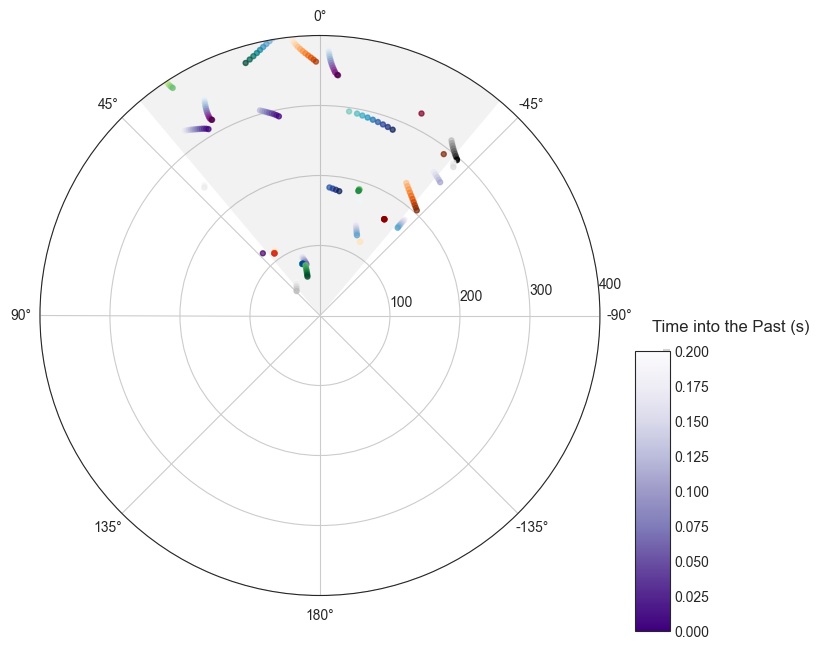

In [17]:
sequential_colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
sequential_colormaps = [map + '_r' for map in sequential_colormaps]  


fig = plt.figure(figsize=(7, 7))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
chunk_numbers = range(110, 115)
counter = 0
max_overlapped_plots = len(sequential_colormaps)*2-1
plot_polar_kwargs_temp = plot_polar_kwargs.copy()
plot_polar_kwargs_temp['show_ff_in_memory'] = False
stop = False

color_visible_area_in_background = True
show_colorbar = True
for chunk in chunk_numbers:
  if stop:
      break
  chunk_df = points_w_more_than_2_ff[points_w_more_than_2_ff['chunk'] == chunk]
  if len(chunk_df) == 0:
    raise ValueError(f"Chunk {chunk} has no data")
  changing_dw_info = pattern_by_points.find_changing_dw_info(chunk_df, monkey_information, ff_caught_T_new, chunk_interval=10,
                                             minimum_time_before_capturing = 0.5)
  changing_dw_info = pattern_by_points.increase_durations_between_points(changing_dw_info, min_duration=2)
  for index, row in changing_dw_info.iterrows():
      counter += 1
      point_index = row['point_index']
      ddw = row['ddw']
      duration = [monkey_information['time'][point_index]-0.2, monkey_information['time'][point_index]]
      ff_dataframe_temp = ff_dataframe.copy()
      if ddw > 0:
          # flip so that the monkey is always accelerating towards the right
          ff_dataframe_temp['ff_angle'] = -ff_dataframe_temp['ff_angle']
    

      fig, axes = plot_polar.PlotPolar(duration,
                  monkey_information,
                  ff_dataframe_temp, 
                  ff_life_sorted,
                  ff_real_position_sorted,
                  ff_caught_T_new,
                  ff_flash_sorted,
                  **plot_polar_kwargs_temp,
                  ff_colormap = sequential_colormaps[counter%len(sequential_colormaps)],
                  target_colormap = sequential_colormaps[counter%len(sequential_colormaps)],
                  show_legend = False,
                  fig = fig,
                  ax = axes,
                  color_visible_area_in_background=color_visible_area_in_background,
                  show_colorbar = show_colorbar,
                  size_increase_for_visible_ff= 8
                      )        
      
      color_visible_area_in_background = False
      show_colorbar = False
      # # Add an annotation at the bottom
      # if ddw > 0: 
      #   annotation = "Angular Acceleration to the Left"
      # else:
      #   annotation = "Angular Acceleration to the Right"
      # axes.annotate(annotation, xy=(0.5, 0.25), xycoords="axes fraction", fontsize=15, ha="center", va="center")

      if counter == max_overlapped_plots:
          print("Reached max_overlapped_plots")
          stop = True
          break


plt.show()
  

# Animation

In [ ]:
stop!

## basic

In [18]:
additional_plotting_kwargs = {'show_eye_positions': False,
                     'show_eye_positions_on_the_right': False,
                     'show_connect_path_eye_positions': False,
                     'show_ff_indices': True,
}

temp_animation_plot_kwargs = data_item.animation_plot_kwargs.copy()
temp_animation_plot_kwargs['images_dir'] = None

for key, value in additional_plotting_kwargs.items():
    temp_animation_plot_kwargs[key] = value
temp_animation_plot_kwargs['show_connect_path_ff'] = False
temp_animation_plot_kwargs['show_connect_path_ff_memory'] = False
temp_animation_plot_kwargs['show_stops'] = False

temp_animation_plot_kwargs['trail_color_var'] = "grey"
plt.rcParams["figure.figsize"] = (10, 10)

In [19]:
import shutil
plt.rcParams['animation.ffmpeg_path'] = shutil.which("ffmpeg")

In [ ]:
# change the default figure size
plt.rcParams["figure.figsize"] = (12, 12)

for i in range(2200, 3000, 20):
    #duration = [i, i+5]
    duration = [i, i+25]
    print(duration)
    video_dir = "/Users/dusiyi/Documents/Multifirefly-Project/for_manual_annotation2"
    file_name = f"time_{duration[0]}_to_{duration[1]}.mp4"
    data_item.make_animation(duration=duration, save_video=True, video_dir=video_dir, file_name=file_name, show_ff_indices=True, 
                                static_plot_on_the_left=False, animation_plot_kwargs=temp_animation_plot_kwargs, plot_time_index=True, show_speed_through_path_color=True,
                                max_num_frames=None, max_duration=None, min_duration=1, set_xy_limits=False)
    HTML(data_item.anim.to_html5_video()) 


## based on trials

In [ ]:

data_item.make_animation_from_a_category("ignore_sudden_flash", max_trial_to_plot=1, num_trials=1, sampling_frame_ratio = 5, additional_kwargs=additional_plotting_kwargs,
                                                        save_video=False, exists_ok=True, dt=0.016, plot_eye_position=True, plot_time_index=True)
# note: if save_video is True, but video_dir is None, then video_dir is set to be the same as self.video_dir eventually
HTML(data_item.anim.to_html5_video())

## +annotation

In [ ]:
data_item.make_animation_from_a_category("disappear_latest", max_trial_to_plot=1, num_trials=2, sampling_frame_ratio = 5, save_video=False, exists_ok=True,
                                                        with_annotation=True, dt=0.016)
# note: if save_video is True, but video_dir is None, then video_dir is set to be the same as self.video_dir eventually
HTML(data_item.anim.to_html5_video())

## of chunks

In [ ]:
reload(intended_targets_classes)

In [ ]:
chunk_numbers = range(20, 21)
additional_kwargs = {'show_connect_path_ff_memory': True,
                     'show_connect_path_ff_except_targets': True,
                     'show_path_when_target_visible': True,
                     'show_connect_path_eye_positions': False}
data_item.make_animation_of_chunks(points_w_more_than_2_ff, monkey_information, chunk_numbers = chunk_numbers, sampling_frame_ratio = 3, 
                                       additional_kwargs=additional_kwargs, exists_ok=True, save_video=False)
HTML(data_item.anim.to_html5_video())                                       